# Distribution Fitting with Python Scipy

The following code is taken from an online [blog post](https://medium.com/@amirarsalan.rajabi/distribution-fitting-with-python-scipy-bb70a42c0aed) 

You have a datastet, a repeated measurement of a variable, and you want to know which probability distribution this variable might come from. Fitting your data to the right distribution is valuable and might give you some insight about it. SciPy is a Python library with many mathematical and statistical tools ready to be used and applied to your data.

In order to start the task, we take Dow Jones Index Data Set as an example which is publicly available [here](http://archive.ics.uci.edu/ml/datasets/Dow+Jones+Index). after downloading the dataset, you can import the data with Pandas:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from six.moves import urllib
import zipfile
from scipy import stats
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
urllib.request.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00312/dow_jones_index.zip","file.zip")

('file.zip', <http.client.HTTPMessage at 0x1ed13c95400>)

In [4]:
zipfile.ZipFile("file.zip").extractall()

In [5]:
df = pd.read_csv("dow_jones_index.data")
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


This is a weekly dataset of Dow Jones Index. Those dollar signs are getting on my nerves, so I delete them by applying a function to my pandas columns:

In [6]:
def omit_s(x):
    return x[1:]
df['high'] = df['high'].apply(omit_s)
df['low'] = df['low'].apply(omit_s)
df['open'] = df['open'].apply(omit_s)
df['close'] = df['close'].apply(omit_s)

In [7]:
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


Ok, problem solved! The columns that we are gonna work with, are ‘volume’ and ‘percent_change_next_weeks_price’. I just randomly chose these two columns, you can choose yours! Let’s also see how many data points each column has:

In [8]:
df.shape

(750, 16)

So each column contains 750 data points. Before fitting any distributions to our data, it’s wise to first plot a histogram of our data and visually observe it:

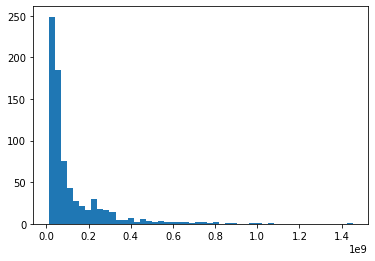

In [9]:
plt.hist(df['volume'], bins=50)
plt.show()

Hmmm, doesn’t look at all like a normal distribution! now let’s also take a look at the column ‘percent_change_next_weeks_price’ :

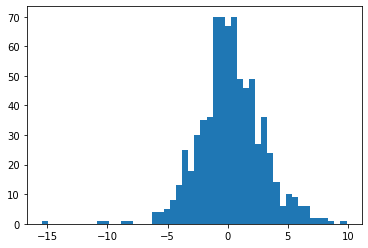

In [10]:
plt.hist(df['percent_change_next_weeks_price'], bins=50)
plt.show()

This one looks like a normal distribution. We just don’t know yet, we have to test it.

Before getting into distribution fitting, let’s review a simple handful of theories. There are a couple of methods to estimate parameters of a distribution based on your data. [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE), [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC), (Maximizing Bayesian Posterior Probability](https://en.wikipedia.org/wiki/Posterior_probability), etc. SciPy performs parameter estimation using MLE ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html)).

When you fit a certain probability distribution to your data, you must then test the goodness of fit. Kolmogorov–Smirnov test is an option and the widely used one. Beware that this test has some limitations on which you can read more [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm) (I sincerely urge you to do so). The test basically gives you a statistic and a p-value, that you have to interpret the results by looking at a K-S test table. We will talk about the interpretation of the test shortly in an example.

So let’s get back to our test data. We want to determine how well our column ‘percent_change_next_weeks_price’ fits a normal distribution (since we naively saw it looks like it’s normally distributed):

In [11]:
dist = getattr(stats, 'norm')
parameters = dist.fit(df['percent_change_next_weeks_price'])
print(parameters)

(0.23846810386666667, 2.67775139226584)


In first line, we get a scipy “normal” distbution object. We could have used the following syntax:
```
from scipy.stats import norm
```
but the first method is a little more flexible and allows the name of the function to be a string variable that we can take from a list (which we will see later).

The second line, we fit the data to the normal distribution and get the parameters. Then we print the parameters. The first parameter (0.23846810386666667) is the mean of the fitted normal distribution and the second parameter (2.67775139226584) is standard deviation of our fitted distribution.
Now let’s perform a Kolmogorov–Smirnov test and check the goodness of fit:

In [12]:
KstestResult = stats.kstest(df['percent_change_next_weeks_price'], "norm", parameters)
print(KstestResult)

KstestResult(statistic=0.04591966870880479, pvalue=0.08200142569744828)


Alright! now we have to interpret the result. We have to look at K-S table

![](https://www.statisticshowto.com/wp-content/uploads/2016/07/k-s-test-table-p-value.png)

Since our sample size contains more than 50 data points (750), we must look at the last row of the table. We want a significance level (α) of 0.05 , so we look at the last row of the third column. The critical value is $1.36/\sqrt{n}$, if our p_value is more than the critical value then the distribution is a good fit.

In [13]:
p_critical = 1.36 / np.sqrt(df.shape[0])
print(p_critical)
print('K-S test passed?', KstestResult.pvalue > p_critical)

0.049660178547135066
K-S test passed? True


Now let’s check the other column of our data, ‘volume’. We are not sure what kind of distribution to test for it. How about trying all distributions in SciPy and performing a K-S test on all fitted distributions?!
SicPy has around [90 continuous distributions](https://docs.scipy.org/doc/scipy/reference/stats.html). We need to fit our data to all of these distributions and compare the results.


In [14]:
list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
for i, dist in enumerate(list_of_dists):
    print(i, dist)

0 alpha
1 anglit
2 arcsine
3 beta
4 betaprime
5 bradford
6 burr
7 burr12
8 cauchy
9 chi
10 chi2
11 cosine
12 dgamma
13 dweibull
14 erlang
15 expon
16 exponnorm
17 exponweib
18 exponpow
19 f
20 fatiguelife
21 fisk
22 foldcauchy
23 foldnorm
24 frechet_r
25 frechet_l
26 genlogistic
27 genpareto
28 gennorm
29 genexpon
30 genextreme
31 gausshyper
32 gamma
33 gengamma
34 genhalflogistic
35 gilbrat
36 gompertz
37 gumbel_r
38 gumbel_l
39 halfcauchy
40 halflogistic
41 halfnorm
42 halfgennorm
43 hypsecant
44 invgamma
45 invgauss
46 invweibull
47 johnsonsb
48 johnsonsu
49 kstwobign
50 laplace
51 levy
52 levy_l
53 logistic
54 loggamma
55 loglaplace
56 lognorm
57 lomax
58 maxwell
59 mielke
60 nakagami
61 ncx2
62 ncf
63 nct
64 norm
65 pareto
66 pearson3
67 powerlaw
68 powerlognorm
69 powernorm
70 rdist
71 reciprocal
72 rayleigh
73 rice
74 recipinvgauss
75 semicircular
76 t
77 triang
78 truncexpon
79 truncnorm
80 tukeylambda
81 uniform
82 vonmises
83 vonmises_line
84 wald
85 weibull_min
86 weibull_ma

In [15]:
results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(df['volume'])
    a = stats.kstest(df['volume'], i, args=param)
    results.append((i,a[0],a[1]))

In [16]:
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

halfcauchy: statistic=0.03887087256332211, pvalue=0.20183502014078858
invgauss: statistic=0.03948353997389775, pvalue=0.18776786186101635
johnsonsu: statistic=0.044185424938288254, pvalue=0.10378934071516199
invweibull: statistic=0.050243977925688355, pvalue=0.04380226739344362
mielke: statistic=nan, pvalue=nan
powerlognorm: statistic=0.04519455411722639, pvalue=0.09059161698733775
nct: statistic=0.04523016932936136, pvalue=0.09015275601704842
exponweib: statistic=0.04706601157682333, pvalue=0.06982558027475971
burr: statistic=0.050123926165586474, pvalue=0.04460536423750627
lognorm: statistic=0.05103977355535111, pvalue=0.03878963721514517
betaprime: statistic=0.05322033344188226, pvalue=0.02753260524176515
invgamma: statistic=0.05332900790496364, pvalue=0.027056110286274082
johnsonsb: statistic=0.05709637394745409, pvalue=0.014450279543746808
f: statistic=0.05720236505041787, pvalue=0.014188756739448355
alpha: statistic=0.05924967503868539, pvalue=0.009904869644000119
gengamma: stati

So let’s take a look at the code. the first line is defining a list that contains the names of almost all SciPy distributions (It contains 87 of them). Next, we define an empty list called results. Next, there is a loop. This loop takes each distribution one by one, fits it to the data, performs K-S test on it and records the result in the results list. Next, the results are sorted based on the highest p-value (Hence the lowest statistic), and they are printed. Now, with regard to the results, it seems the best fitted distribution is halfcauchy distribution, which is of the family of [heavy-tailed distributions](https://en.wikipedia.org/wiki/Heavy-tailed_distribution).

# Homework

Using the distribution with the best fit plot the 'volume' data and also the probability density function for the distribution.
Hints:
* Read the documentation about the scipy stats distributions
* Read the documentation about the matplotlib histogram function
* Think about whether your data is normalized or not
* Think about how best to present multiple different types of plot (histogram + line?) 

Text(0, 0.5, 'Frequency')

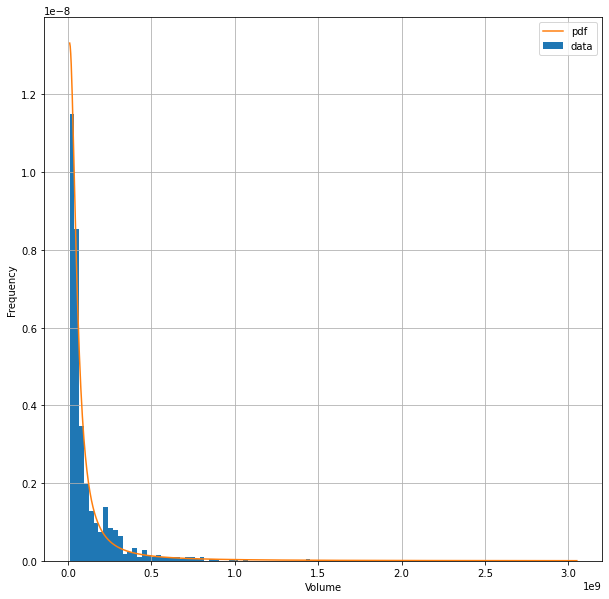

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(df['volume'], bins=50, density=True, label='data')
dist = getattr(stats, 'halfcauchy')
param = dist.fit(df['volume'])
distribution = dist(*param)
start = distribution.ppf(0.01)
end = distribution.ppf(0.99)
x = np.linspace(start, end, 1001)
y = distribution.pdf(x)
ax.plot(x, y, label='pdf')
ax.grid()
ax.legend()
ax.set_xlabel('Volume')
ax.set_ylabel('Frequency')